In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# Pauli matricies

si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

In [3]:
#### Simulation parameters ####
dt = 0.1
T = 50.0
times = np.arange(0.0, T+dt, dt)

N_cycles = 20       # Stevilo ciklov algoritma


#### TFIM system parameters ####
L = 3  # length of chain
N = 2*L # total number of sites

J = 1.0
hx = 1
hz = 1

#### Coupling and bath parameters ####
Jc = 0.8
Bi = 4.0
Bf = 0.0

hb = 0.8

tfim_parameters = [J, hx, hz]
bath_parameters = [hb, Bi, Bf, T]
coupling_parameters = [Jc, T]

time_dependant_functions_coeffs = {'Jc': Jc, 'T': T, 'Bi': Bi, 'Bf': Bf}

In [4]:
def tfim_hamiltonian(L, tfim_params):

    sx_list = []
    sy_list = []
    sz_list = []

    N = 2*L

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(qt.tensor(op_list))

        op_list[n] = sz
        sz_list.append(qt.tensor(op_list))

    # Ising model hamiltonian construction
    J, hx, hz = tfim_params

    J_list = np.ones(L) * J
    hx_list = np.ones(L) * hx
    hz_list = np.ones(L) * hz

    H_ising_chain = 0

    for n in range(L):
        H_ising_chain += -hx_list[n] * sx_list[n]
        H_ising_chain += -hz_list[n] * sz_list[n]

    for n in range(L):
        H_ising_chain += - J_list[n] * sz_list[n] * sz_list[((n+1)%L)]

    return H_ising_chain

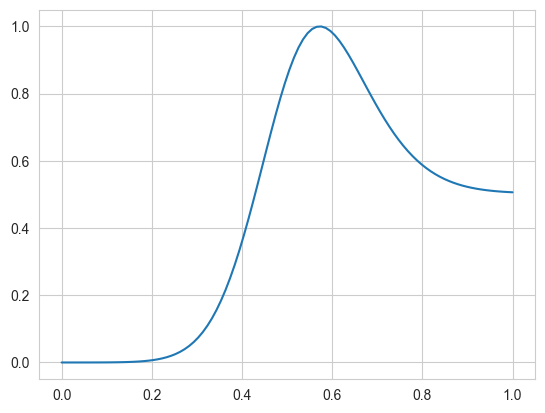

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.49364174+0.j         0.        -0.49995958j]
 [0.        +0.49995958j 0.5063564 +0.j        ]]


In [86]:
def single_bit_rotation(hx_type,hz_type):
    

    time_dependant_functions_coeffs = {"hx_pulse_type": hx_type, "hz_pulse_type": hz_type}

    t0 = 0
    tmax = 1

    def xdrive(t, args):
        tmid = (tmax-t0)/2
        sigma = (tmax-t0)/6
        pulse_size = args["hx_pulse_type"]

        return 1/2*pulse_size*1/np.sqrt(2*np.pi*sigma**2) *np.exp(-(t-tmid)**2/(2*sigma**2))

    def zdrive(t, args):
        tmid = (tmax-t0)/2
        sigma = (tmax-t0)/6
        pulse_size = args["hz_pulse_type"]

        return 1/2*pulse_size*1/np.sqrt(2*np.pi*sigma**2) *np.exp(-(t-tmid)**2/(2*sigma**2))

    H = [[sx, xdrive], [sz, zdrive]]

    tlist = np.linspace(t0,tmax,100)
    upstate = qt.basis(2,0)
    upstate_density_matrix = upstate * upstate.dag()
    psi0 = upstate_density_matrix

    result = qt.mesolve(H, psi0, tlist, c_ops=[], e_ops=[], args=time_dependant_functions_coeffs)

    psiEnd = result.states[-1]

    vals = []
    for i in range(len(tlist)):
        vals.append(np.abs(result.states[i][1,1]))
        

    plt.plot(tlist,vals)
    plt.show()

    print(psi0)
    print(psiEnd)

single_bit_rotation(hx_type=3*np.pi/2, hz_type=0)



####PREVERI ČE RES DELAJO PULZI KOT BI MORALI (3pi/2 bi mogu dat gor-dol, ne?) --> pozor, density matrix je to (so skal prod not!, ne gole vrednosti)






